## Calculating correlations between SimLex-999 and similarity from pretrained models

In [10]:
from __future__ import print_function
import gensim
print(gensim.__version__) 
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau, linregress
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText

C:\Users\Kittask\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


3.4.0


Comments after the meeting on 13.12.2018 :
1. Compute the correlations also for English. They will help you to better interpret the results. DONE
2. Compute the correlations for different criteria (e.g. they can be the level of concretness for example)
3. The interface for accessing the Estonian Wordnet (http://estwn-test.keeleressursid.ee/docs/#/api)
4. For accessing the Princeton Wordnet I reccomend the NLTK interface (it is good and it has many 
similarity measures implemented). Look here : http://www.nltk.org/howto/wordnet.html

In [133]:
#Loading pretrained models 

wiki_model_est = KeyedVectors.load_word2vec_format('wiki.et.vec')

wiki_model_eng = KeyedVectors.load_word2vec_format('wiki.en.vec')

FileNotFoundError: [Errno 2] No such file or directory: 'wiki.en.vec'

In [84]:
lemma_est_model_cbow100 = KeyedVectors.load_word2vec_format('lemmas.cbow.s100.w2v.bin', binary=True)
lemma_est_model_sg100 = KeyedVectors.load_word2vec_format('lemmas.sg.s100.w2v.bin', binary=True)
lemma_est_model_cbow200 = KeyedVectors.load_word2vec_format('lemmas.cbow.s200.w2v.bin', binary=True)
lemma_est_model_sg200 = KeyedVectors.load_word2vec_format('lemmas.sg.s200.w2v.bin', binary=True)
word_est_model_cbow100 = KeyedVectors.load_word2vec_format('words.cbow.s200.w2v.bin', binary=True)
word_est_model_sg100 = KeyedVectors.load_word2vec_format('words.sg.s100.w2v.bin', binary=True)
word_est_model_cbow200 = KeyedVectors.load_word2vec_format('words.cbow.s200.w2v.bin', binary=True)
word_est_model_sg200 = KeyedVectors.load_word2vec_format('words.sg.s200.w2v.bin', binary=True)


Similarity from model trained on wikipedia is scaled to 0-1 and model trained on Estonian Reference Corpus is scaled to -1 to 1. 

In [14]:
# Loading the translated SimLex-999 to a dataframe, sorting the frame based on the similarity 

file_name = "SimLex-999-eng-est1.xlsx"
data = pd.read_excel(file_name)
data = data.sort_values('SimLex999')
data.head()


,word 1,word 2,sõna 1,sõna 2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
829,shrink,grow,kahanema,kasvatama,V,0.23,3.55,3.03,2,0.5,1,1.20
75,new,ancient,uus,muistne,A,0.23,2.81,2.04,1,0.2,0,0.46
735,island,task,saar,ülesanne,N,0.30,4.96,2.84,3,0.0,0,0.96
742,chapter,tail,peatükk,saba,N,0.30,3.43,4.96,3,0.0,0,1.57
110,dirty,narrow,räpane,kitsas,A,0.30,4.23,3.04,2,0.0,0,0.89


In [95]:
def getSimilarityFromModel(model):
    df = pd.DataFrame(columns=["word1", "word2","Sõna1", "Sõna2", "SimLex999", "SimFromModel"])
    missing = pd.DataFrame(columns=["word1", "word2", "Sõna 1", "Sõna 2"])
    for index, row in data.iterrows():
        word1 = row["sõna 1"].lower().strip()
        word2 = row["sõna 2"].lower().strip()
        eword1 = row["word 1"]
        eword2 = row["word 2"]
        simlex = row["SimLex999"]
        try: 
            sim = model.similarity(word1, word2)
            df = df.append({"word1":eword1, "word2": eword2,"Sõna1":word1, "Sõna2":word2, "SimLex999":simlex, "SimFromModel":sim}, ignore_index=True)
        except: 
            missing = missing.append({"word1":eword1, "word2": eword2, "Sõna 1":word1, "Sõna 2":word2}, ignore_index=True)
    return df, missing

In [91]:
def evaluate(df):
    pearson = pearsonr(df.SimLex999, df.SimFromModel)
    spearman = spearmanr(df.SimLex999, df.SimFromModel)
    kendall = kendalltau(df.SimLex999, df.SimFromModel)
    return {"pearson":pearson, "spearman":spearman, "kendall": kendall}

In [109]:
def transform(row):
    return 10*(row["SimFromModel"] - minV)/(maxV-minV)

In [120]:
def printCorrelations(dic):
    print("Pearson correlation: " + str(dic["pearson"][0]))
    print("Spearman correlation: " + str(dic["spearman"][0]))
    print("Kendall tau correlation: " + str(dic["kendall"][0]))

In [122]:
def createScatterPlot(df):
    plt.scatter(df.SimLex999, df.SimFromModel)
    plt.show()

Lemmatized model cbow 100
Missing pairs 10
Pearson correlation: 0.2744449774738324
Spearman correlation: 0.26845550523247214
Kendall tau correlation: 0.1806779651240438


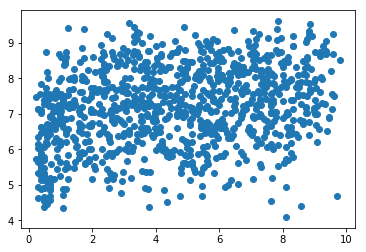

In [125]:
p, m = getSimilarityFromModel(lemma_est_model_cbow100)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Lemmatized model cbow 100")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Lemmatized model cbow 200
Missing pairs 10
Pearson correlation: 0.29381924392854325
Spearman correlation: 0.2893651862892572
Kendall tau correlation: 0.19569686711442488


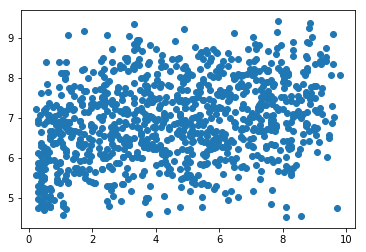

In [126]:
p, m = getSimilarityFromModel(lemma_est_model_cbow200)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Lemmatized model cbow 200")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Lemmatized model sg 100
Missing pairs 10
Pearson correlation: 0.29725418929930886
Spearman correlation: 0.28915034231874365
Kendall tau correlation: 0.19478228078349782


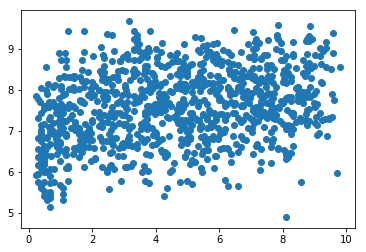

In [127]:
p, m = getSimilarityFromModel(lemma_est_model_sg100)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Lemmatized model sg 100")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Lemmatized model sg 200
Missing pairs 10
Pearson correlation: 0.31230076089912406
Spearman correlation: 0.3102949015866093
Kendall tau correlation: 0.20935004153440812


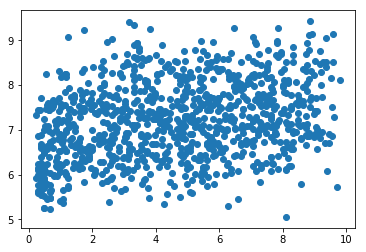

In [128]:
p, m = getSimilarityFromModel(lemma_est_model_sg200)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Lemmatized model sg 200")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Word model cbow 100
Missing pairs 6
Pearson correlation: 0.26070985205446945
Spearman correlation: 0.2601235527661671
Kendall tau correlation: 0.17775688181630334


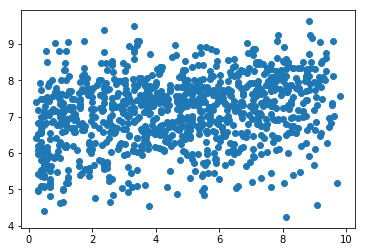

In [129]:
p, m = getSimilarityFromModel(word_est_model_cbow100)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Word model cbow 100")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Word model cbow 200
Missing pairs 6
Pearson correlation: 0.26070985205446945
Spearman correlation: 0.2601235527661671
Kendall tau correlation: 0.17775688181630334


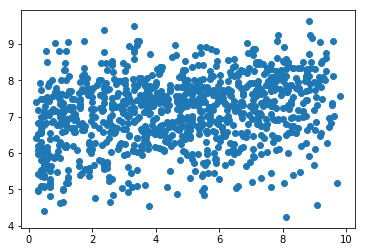

In [130]:
p, m = getSimilarityFromModel(word_est_model_cbow200)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Word model cbow 200")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Word model sg 100
Missing pairs 6
Pearson correlation: 0.27166793503856695
Spearman correlation: 0.26838757852155465
Kendall tau correlation: 0.1824394586520012


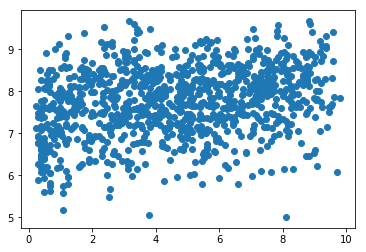

In [131]:
p, m = getSimilarityFromModel(word_est_model_sg100)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("Word model sg 100")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

word model sg 200
Missing pairs 6
Pearson correlation: 0.27981301340830855
Spearman correlation: 0.2759353757611878
Kendall tau correlation: 0.1868901441934899


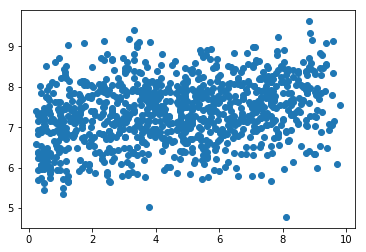

In [132]:
p, m = getSimilarityFromModel(word_est_model_sg200)
minV,maxV = -1,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("word model sg 200")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

wiki est
Missing pairs 23
Pearson correlation: 0.2901529242892457
Spearman correlation: 0.30061057607771147
Kendall tau correlation: 0.20538896023198236


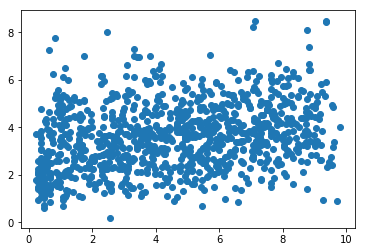

In [134]:
p, m = getSimilarityFromModel(wiki_model_est)
minV,maxV = 0,1
p["SimFromModel"] = p.apply(transform, axis=1)
print("wiki est")
print("Missing pairs " + str(m.shape[0]))
printCorrelations(evaluate(p))
createScatterPlot(p)

Difference between supper and dinner? Dinner is more like a biggest meal of the day, hard to translate into estonian. <br>
taxi - cab - Don't have 2 different words in estonian to differentiate these words, can use word 'taksi' or 'taksiauto' but these are not really common <br>
Disorganize - 'desorganiseerima' is really ugly word in estonian :(  Didn't find any better variants tho. <br>
cooperate - 'koopereerima' is again really ugly word and not really used often. More suitable would be 'koostööd tegema' but this is made up of 2 words so.. <br>
Difference between cradle and crib? Both should mean child bed. In estonian both should be 'häll' then, crib is also translated to 'võrevoodi' which is not often used <br>
Some words are in plural form - like teeth, men, clothes.  <br>
north and bottom both mean "põhi" in estonian. There are 3 cardinal directions in this dataset, for others I could use the shorter version, for example south is 'lõuna' (which also means lunch in estonian.. I translated lunch as 'lõunasöök')  not 'lõunakaar' like I had to do with north - 'põhjakaar'. Maybe I should translate others to this longer format aswell? <br>
Tax means 'maks' which also means liver in estonian. Should I translate it into something else instead? <br>
What is the difference between motor and engine? - In estonia both should be 'mootor'. Engine should be a  specific type of motor. Really hard ot translate into estonian. So I just but one as "jõumasin" and the other "mootor". Not sure if correct. <br>
Choke - does this mean like choking someone or the difficulty in breathing? If it means choking someone - then it would be  'kägistama' in estonian, but if it means more like difficulty in breathing then it would mean 'lämbuma' 



In [222]:
est_model.similarity("põhjakaar", "lõunakaar")

C:\Users\claudia.kittask\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if veclen > 0.0:


0.7352413

In [232]:
wiki_model.similarity("lõuna", "ida")

C:\Users\claudia.kittask\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if veclen > 0.0:


0.44991776

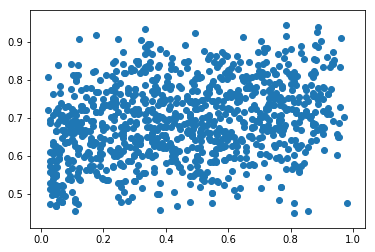

In [88]:
plt.scatter(df1.SimLex999, df1.SimFromEstModel)

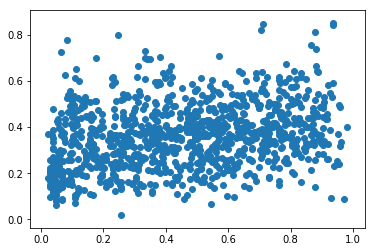

In [87]:
plt.scatter(df2.SimLex999, df2.SimFromWikiModel_est)

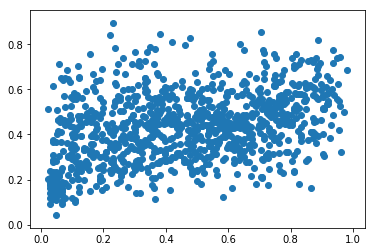

In [86]:
plt.scatter(df3.SimLex999, df3.SimFromWikiModel_eng)

## Calculating Pearson correlation

In [89]:
pearson_wiki = pearsonr(df1.SimLex999, df1.SimFromEstModel)
pearson_est = pearsonr(df2.SimLex999, df2.SimFromWikiModel_est)
pearson_eng = pearsonr(df3.SimLex999, df3.SimFromWikiModel_eng)
print("Pearson correlations for model \ntrained on est wiki: " + str(round(pearson_wiki[0],3)) 
     + "\ntrained on est corpus: " + str(round(pearson_est[0],3)) + "\ntrained on english wiki: " + str(round(pearson_eng[0],2)))

Pearson correlations for model 
trained on est wiki: 0.281
trained on est corpus: 0.297
trained on english wiki: 0.39


## Calculating Spearman's rank correlation

In [90]:
spearmans_wiki = spearmanr(df1.SimLex999, df1.SimFromEstModel)
spearmans_est = spearmanr(df2.SimLex999, df2.SimFromWikiModel_est)
spearmans_eng = spearmanr(df3.SimLex999, df3.SimFromWikiModel_eng)
print("Spearsons correlations for model \ntrained on est wiki: " + str(round(spearmans_wiki[0],3)) 
     + "\ntrained on est corpus: " + str(round(spearmans_est[0],3)) + "\ntrained on english wiki: " + str(round(spearmans_eng[0],2)))

Spearsons correlations for model 
trained on est wiki: 0.277
trained on est corpus: 0.304
trained on english wiki: 0.38


## Calculating Kendall rank correlation

In [91]:
kendall_wiki = kendalltau(df1.SimLex999, df1.SimFromEstModel)
kendall_est = kendalltau(df2.SimLex999, df2.SimFromWikiModel_est)
kendall_eng = kendalltau(df3.SimLex999, df3.SimFromWikiModel_eng)
print("Spearsons correlations for model \ntrained on est wiki: " + str(round(kendall_wiki[0],3)) 
     + "\ntrained on est corpus: " + str(round(kendall_est[0],3)) + "\ntrained on english wiki: " + str(round(kendall_eng[0],2)))

Spearsons correlations for model 
trained on est wiki: 0.187
trained on est corpus: 0.208
trained on english wiki: 0.27


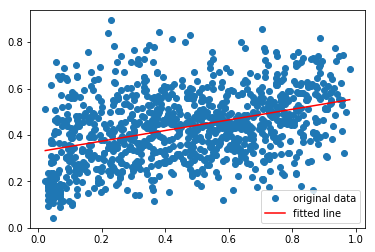

In [92]:
np.random.seed(12345678)
slope, intercept, r_value, p_value, std_err =  linregress(df3.SimLex999, df3.SimFromWikiModel_eng)
plt.plot(df3.SimLex999, df3.SimFromWikiModel_eng, 'o', label='original data')
plt.plot(df3.SimLex999, intercept + slope*df3.SimLex999, 'r', label="fitted line")
plt.legend()


Correlation between english model similarity and SimLex-999 is much higher than with estonian model. Possible reason is the translation issue. Some wordpairs can have different meanings in estonian than in enlgish.

In [95]:
import requests

In [435]:
url = "http://estwn-test.keeleressursid.ee/api/v1/fn/nch/?ids=844063,849473"
headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
request = requests.get(url, headers)
response = request.json()
response

{'count': 1,
 'next': None,
 'previous': None,
 'results': [{'id': 849473,
   'lexicon': 13,
   'label': '8471-n',
   'synset_type': 'C',
   'status': 'N',
   'domain': '',
   'comment': None,
   'primary_definition': 'see, kes või mis on olemas, eksisteerib',
   'variants_str': '[olev_2(n)]',
   'synset_definitions': [],
   'relations': [{'id': 1979286,
     'a_synset': 849473,
     'b_synset': 844063,
     'a_label': '8471-n [olev_2(n)] - see, kes või mis on olemas, eksisteerib',
     'b_label': '79851-n [antikristus_1(n)] - maailmalõpueelse kurjuse kehastus, kelle võidab taastulev Kristus',
     'rel_type': 962,
     'status': 'D',
     'created_by': '',
     'date_created': '2019-01-20T17:20:52.193061Z',
     'updated_by': 'sandra',
     'date_updated': '2018-11-29T22:48:06.806555Z'},
    {'id': 1996483,
     'a_synset': 849473,
     'b_synset': 832673,
     'a_label': '8471-n [olev_2(n)] - see, kes või mis on olemas, eksisteerib',
     'b_label': '695-n [aine_1(n), mateeria_1(n), 

In [273]:
url = "http://estwn-test.keeleressursid.ee/api/v1/hypos/?id=809186"
headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
request = requests.get(url, headers)
response = request.json()
response

[{'id': 1945524,
  'a_synset': 809186,
  'b_synset': 820250,
  'rel_text': 'has_hyponym',
  'synset_text': '58419-n [esisild_1(n)] - mootorsõiduki sõlm, millele toetub kere esiosa ja mille külge on kinnitatud esirattad (EKSS)'}]

In [432]:
url = "http://estwn-test.keeleressursid.ee/api/v1/sense/?word=karu&pos=n"
headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
request = requests.get(url, headers)
response = request.json()
r = response.get('results')[0].get('synset')
print(r)

791938


In [425]:
url = "http://estwn-test.keeleressursid.ee/api/v1/hypos/?id=832673"
headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
request = requests.get(url, headers)
response = request.json()
ids = [response[i].get('b_synset') for i in range(len(response))]
print(response)
print(ids)


[{'id': 1938240, 'a_synset': 832673, 'b_synset': 772310, 'rel_text': 'has_hyponym', 'synset_text': '15271-n [räbu_1(n), šlakk_1(n)] - metallisulatuses vedelmetalli pinnale tekkiv kergsulav mineraalse sulami kiht, mis tahkudes muutub kivi- v. klaasitaoliseks aineks.'}, {'id': 1938259, 'a_synset': 832673, 'b_synset': 793504, 'rel_text': 'has_hyponym', 'synset_text': '34346-n [substants_1(n)] - objektiivse reaalsuse olemuslik ühtsus, kõigi asjade ja nähtuste jääv alus, olemus (EKSS)'}, {'id': 1938284, 'a_synset': 832673, 'b_synset': 801457, 'rel_text': 'has_hyponym', 'synset_text': '41504-n [settematerjal_1(n)] - settinud aine (EKSS)'}, {'id': 1938314, 'a_synset': 832673, 'b_synset': 810448, 'rel_text': 'has_hyponym', 'synset_text': '49598-n [aroomaine_1(n)]'}, {'id': 1938316, 'a_synset': 832673, 'b_synset': 810914, 'rel_text': 'has_hyponym', 'synset_text': '50015-n [agar_1(n)]'}, {'id': 1938353, 'a_synset': 832673, 'b_synset': 820126, 'rel_text': 'has_hyponym', 'synset_text': '58307-n [h

In [407]:
def getSynsetid(word, pos):
    url = "http://estwn-test.keeleressursid.ee/api/v1/sense/?word="+word +"&pos="+pos
    headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
    request = requests.get(url, headers)
    response = request.json()
    return response.get('results')[0].get('synset')
def getAllHyperonyms(id):
    url = "http://estwn-test.keeleressursid.ee/api/v1/hypers/?id="+str(id)
    headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
    request = requests.get(url, headers)
    response = request.json()
    ida = [response[i].get('a_synset') for i in range(len(response)) if response[i].get('a_synset')!=id]
    idb = [response[i].get('b_synset') for i in range(len(response)) if response[i].get('b_synset')!= id]
    return ida+idb

In [406]:
def getAllHypos(id):
    url = "http://estwn-test.keeleressursid.ee/api/v1/hypos/?id="+str(id)
    headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
    request = requests.get(url, headers)
    response = request.json()
    idb = [response[i].get('b_synset') for i in range(len(response)) if response[i].get('b_synset')!= id]
    print(response)
    return idb
print(getAllHypos(851894))


[{'id': 1941106, 'a_synset': 851894, 'b_synset': 851755, 'rel_text': 'has_hyponym', 'synset_text': '9378-n [maandamine_2(n)] - nt elektrijuhtmeid'}, {'id': 1941107, 'a_synset': 851894, 'b_synset': 828979, 'rel_text': 'has_hyponym', 'synset_text': '66275-n [tuts_1(n)] - väliskeermega toruliitmik torude või voolikute omavaheliseks ühendamiseks (EKSS)'}, {'id': 1970621, 'a_synset': 851894, 'b_synset': 825677, 'rel_text': 'has_hyponym', 'synset_text': '63302-n [pleiss_1(n)] - kahe köie- v. trossiotsa ühendus, mis saadakse nende otste keermeid üksteisega punudes'}, {'id': 1970623, 'a_synset': 851894, 'b_synset': 811014, 'rel_text': 'has_hyponym', 'synset_text': '50105-n [adhesioon_1(n)] - maalimisel kahe materjali kokkupuutel tekkiv külgekleepumine'}, {'id': 1979152, 'a_synset': 851894, 'b_synset': 799582, 'rel_text': 'has_hyponym', 'synset_text': '39818-n [jätkukoht_2(n), põkk_1(n)] - otsakuti ühendamise koht (EKSS)'}, {'id': 1979153, 'a_synset': 851894, 'b_synset': 799581, 'rel_text': 'ha

In [429]:
visited = []
def findPath(s1, s2, p):
    hyp = getAllHyperonyms(s1) + getAllHypos(s1)
    if s2 in hyp: 
        print("LEITUDDDDD")
        return p+1
    elif hyp == []:
        return 0
    else: 
        for h in hyp: 
            if h not in visited: 
                
                print(p)
                findPath(h, s2, p+1)
            

In [430]:
findPath(791938,780399,0 )

[]
0
[{'id': 1938240, 'a_synset': 832673, 'b_synset': 772310, 'rel_text': 'has_hyponym', 'synset_text': '15271-n [räbu_1(n), šlakk_1(n)] - metallisulatuses vedelmetalli pinnale tekkiv kergsulav mineraalse sulami kiht, mis tahkudes muutub kivi- v. klaasitaoliseks aineks.'}, {'id': 1938259, 'a_synset': 832673, 'b_synset': 793504, 'rel_text': 'has_hyponym', 'synset_text': '34346-n [substants_1(n)] - objektiivse reaalsuse olemuslik ühtsus, kõigi asjade ja nähtuste jääv alus, olemus (EKSS)'}, {'id': 1938284, 'a_synset': 832673, 'b_synset': 801457, 'rel_text': 'has_hyponym', 'synset_text': '41504-n [settematerjal_1(n)] - settinud aine (EKSS)'}, {'id': 1938314, 'a_synset': 832673, 'b_synset': 810448, 'rel_text': 'has_hyponym', 'synset_text': '49598-n [aroomaine_1(n)]'}, {'id': 1938316, 'a_synset': 832673, 'b_synset': 810914, 'rel_text': 'has_hyponym', 'synset_text': '50015-n [agar_1(n)]'}, {'id': 1938353, 'a_synset': 832673, 'b_synset': 820126, 'rel_text': 'has_hyponym', 'synset_text': '58307

[]
2
[{'id': 1944563, 'a_synset': 785230, 'b_synset': 770916, 'rel_text': 'has_hyponym', 'synset_text': '14016-n [karvanäss_1(n), karvane_1(n), karvik_2(n)] - karvane olend'}, {'id': 1944577, 'a_synset': 785230, 'b_synset': 772826, 'rel_text': 'has_hyponym', 'synset_text': '15736-n [ebard_1(n), monstrum_1(n), soerd_1(n), väärakas_1(n), väärsünnitis_1(n), värdjas_1(n)] - ulatuslike väärarenditega olend või inimene'}, {'id': 1946166, 'a_synset': 785230, 'b_synset': 775107, 'rel_text': 'has_hyponym', 'synset_text': '1778-n [elusolend_1(n), elusorganism_1(n), isend_1(n), organism_2(n)] - elusorganism, hrl. inimene v. loom'}, {'id': 1946228, 'a_synset': 785230, 'b_synset': 816451, 'rel_text': 'has_hyponym', 'synset_text': '549-n [kujuteldav olend_1(n), väljamõeldud olend_1(n)] - inimeste kujutluses olevad olendid, keda reaalselt ei eksisteeri'}, {'id': 1974133, 'a_synset': 785230, 'b_synset': 787040, 'rel_text': 'has_hyponym', 'synset_text': '28529-n [gigant_1(n), hiid_2(n), hiiglane_1(n)] 

[{'id': 1943120, 'a_synset': 782057, 'b_synset': 852255, 'rel_text': 'has_hyponym', 'synset_text': '9828-n [mängija_1(n), mängumees_2(n)] - pillimängimise kohta'}, {'id': 1943122, 'a_synset': 782057, 'b_synset': 837995, 'rel_text': 'has_hyponym', 'synset_text': '7438-n [ahv_2(n)] - ebameeldiva välimusega, edeva v. kedagi, midagi matkiva, järeleahviva inimese kohta'}, {'id': 1943123, 'a_synset': 782057, 'b_synset': 852204, 'rel_text': 'has_hyponym', 'synset_text': '9782-n [autoriteet_2(n), keegi_1(n), mõjumees_1(n), tuntu_1(n)] - vaimse mõjuvõimuga ning lugupeetud isik; üldise tunnustuse pälvinud isik, omal alal tunnustatud spetsialist'}, {'id': 1943124, 'a_synset': 782057, 'b_synset': 766612, 'rel_text': 'has_hyponym', 'synset_text': '10142-n [must_1(n), mustanahaline_1(n), neeger_1(n)] - neegrirassi kuuluv tumedanahaline kräsusjuukseline paksude huulte ja laia ninaga inimene (algselt Aafrikas, hiljem ka Ameerikas ja mujalgi)'}, {'id': 1943125, 'a_synset': 782057, 'b_synset': 770248, '

[]
6
[]
6
[]
6
[]
6
[]
5
[]
5
[]
5
[{'id': 1978252, 'a_synset': 766612, 'b_synset': 844153, 'rel_text': 'has_hyponym', 'synset_text': '79932-n [asande_1(n)] - neegrirahvas Kesk-Aafrikas'}, {'id': 2057866, 'a_synset': 766612, 'b_synset': 840497, 'rel_text': 'has_hyponym', 'synset_text': '76641-n [neegritar_1(n)]'}, {'id': 2123526, 'a_synset': 766612, 'b_synset': 843926, 'rel_text': 'has_hyponym', 'synset_text': '79728-n [afroameeriklane_1(n)] - Ameerikas elav neeger'}]
6
[]
6
[]
6
[]
5
[{'id': 1950147, 'a_synset': 770248, 'b_synset': 821414, 'rel_text': 'has_hyponym', 'synset_text': '59467-n [maksuvõlgnik_1(n)] - isik, kellel on maksud maksmata'}, {'id': 1971700, 'a_synset': 770248, 'b_synset': 832153, 'rel_text': 'has_hyponym', 'synset_text': '69131-n [solidaarvõlgnik_1(n)] - võlgnik, kellelt võlausaldaja võib nõuda kohustuse täielikku või osalist täitmist kas kõigi teiste võlgnikega koos või igaühelt eraldi'}, {'id': 1977488, 'a_synset': 770248, 'b_synset': 850424, 'rel_text': 'has_hy

[{'id': 2119275, 'a_synset': 795090, 'b_synset': 795891, 'rel_text': 'has_hyponym', 'synset_text': '36496-n [matja_4(n), sängitaja_1(n)]'}]
7
[]
6
[{'id': 2002942, 'a_synset': 798028, 'b_synset': 794178, 'rel_text': 'has_hyponym', 'synset_text': '34953-n [rõõmustaja_1(n)]'}, {'id': 2032585, 'a_synset': 798028, 'b_synset': 798027, 'rel_text': 'has_hyponym', 'synset_text': '38418-n [vihastaja_2(n)]'}, {'id': 2149124, 'a_synset': 798028, 'b_synset': 794177, 'rel_text': 'has_hyponym', 'synset_text': '34952-n [kurvastaja_1(n), nukrustaja_1(n), nukrutseja_1(n)]'}]
7
[]
7
[{'id': 2032584, 'a_synset': 798027, 'b_synset': 794300, 'rel_text': 'has_hyponym', 'synset_text': '35062-n [raevleja_1(n), raevutseja_1(n)]'}]
8
[]
7
[]
6
[]
6
[]
6
[]
6
[]
6
[]
6
[]
6
[]
6
[]
6
[{'id': 2119316, 'a_synset': 795748, 'b_synset': 797625, 'rel_text': 'has_hyponym', 'synset_text': '38056-n [ähmitseja_1(n)]'}]
7
[]
6
[{'id': 2060978, 'a_synset': 794366, 'b_synset': 794876, 'rel_text': 'has_hyponym', 'synset_text'

[]
8
[]
8
[]
8
[]
8
[{'id': 2002701, 'a_synset': 794376, 'b_synset': 796065, 'rel_text': 'has_hyponym', 'synset_text': '36652-n [molutaja_2(n)]'}, {'id': 2119200, 'a_synset': 794376, 'b_synset': 795321, 'rel_text': 'has_hyponym', 'synset_text': '35983-n [jõllitaja_1(n), pungitaja_1(n)]'}]
9
[]
9
[]
8


KeyboardInterrupt: 

In [ ]:
df5 = pd.DataFrame(columns=["word1", "word2","Sõna1", "Sõna2", "SimLex999", "path_sim"])

for index, row in data.iterrows():
    word1 = row["sõna 1"].lower().strip()
    word2 = row["sõna 2"].lower().strip()
    
    eword1 = row["word 1"]
    eword2 = row["word 2"]
    simlex = row["SimLex999"]/10
    if row["POS"] == "N":
        w1 = getSynsetid(word1, 'n')
        w2 = getSynsetid(word2, 'n')
        
        path_sim = path_similarity(w1,w2)
        if path_sim != None:
            df4 = df4.append({"word1":eword1, "word2": eword2,"Sõna1":word1, "Sõna2":word2, "SimLex999":simlex, "path_sim":path_sim }, ignore_index=True)
    elif row["POS"] == "V":
        w1 = wn.synsets(eword1, pos=wn.VERB)[0]
        w2 = wn.synsets(eword2, pos=wn.VERB)[0]
        path_sim = path_similarity(w1, w2)

        if path_sim != None:
            df4 = df4.append({"word1":eword1, "word2": eword2,"Sõna1":word1, "Sõna2":word2, "SimLex999":simlex, "path_sim":path_sim}, ignore_index=True)



In [11]:
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

brown_ic = wordnet_ic.ic('ic-brown.dat')
semcor_ic = wordnet_ic.ic('ic-semcor.dat')

In [354]:
a = wn.synsets('dog', pos=wn.NOUN)[0]
b = wn.synsets('hunting_dog', pos=wn.NOUN)[0]
a.path_similarity(b)


0.5

In [12]:
def findMax(ws1, ws2):
    lch, path,wup, res,jcn,lin = [0], [0], [0], [0], [0], [0]
    for w1 in ws1: 
        for w2 in ws2: 
            lch.append(w1.lch_similarity(w2))
            path.append(w1.path_similarity(w2))
            wup.append(w1.wup_similarity(w2))
            res.append(w1.res_similarity(w2, brown_ic))
            jcn.append(w1.jcn_similarity(w2, brown_ic))
            lin.append(w1.lin_similarity(w2, brown_ic))
    return {"lch":max(lch), "path":max(path), "wup":max(wup), "res":max(res), "jcn":max(jcn), "lin":max(lin)}
                    

In [35]:
df4 = pd.DataFrame(columns=["word1", "word2","Sõna1", "Sõna2", "SimLex999", "path_sim", "lch_similarity", "wup_similarity","res_similarity", "jcn_similarity", "lin_similarity"])

for index, row in data.iterrows():
    word1 = row["sõna 1"].lower().strip()
    word2 = row["sõna 2"].lower().strip()
    
    eword1 = row["word 1"]
    eword2 = row["word 2"]
    simlex = row["SimLex999"]
    if row["POS"] == "N":
        w1_senses = wn.synsets(eword1, pos=wn.NOUN)
        w2_senses = wn.synsets(eword2, pos=wn.NOUN)
        sims = findMax(w1_senses, w2_senses)
        path = sims.get("path")
        lch = sims.get("lch")
        wup= sims.get("wup")
        res= sims.get("res")
        jcn= sims.get("jcn")
        lin= sims.get("lin")
        if path!= None:
            df4 = df4.append({"word1":eword1, "word2": eword2,"Sõna1":word1, "Sõna2":word2,"w1_senses":w1_senses, "w2_senses":w2_senses, "SimLex999":simlex, "path_sim":path, "lch_similarity":lch, "wup_similarity":wup, "res_similarity":res, "jcn_similarity":jcn, "lin_similarity":lin }, ignore_index=True)


    elif row["POS"] == "V":
        w1_senses = wn.synsets(eword1, pos=wn.VERB)
        w2_senses = wn.synsets(eword2, pos=wn.VERB)
        sims = findMax(w1_senses, w2_senses)
        path = sims.get("path")
        lch = sims.get("lch")
        wup= sims.get("wup")
        res= sims.get("res")
        jcn= sims.get("jcn")
        lin= sims.get("lin")
        if path!= None:
            df4 = df4.append({"word1":eword1, "word2": eword2,"Sõna1":word1, "Sõna2":word2,"w1_senses":w1_senses, "w2_senses":w2_senses, "SimLex999":simlex, "path_sim":path, "lch_similarity":lch, "wup_similarity":wup, "res_similarity":res, "jcn_similarity":jcn, "lin_similarity":lin }, ignore_index=True)

        


In [21]:
wn.synsets("shrink")

[Synset('psychiatrist.n.01'),
 Synset('shrivel.v.01'),
 Synset('flinch.v.01'),
 Synset('shrink.v.03'),
 Synset('shrink.v.04'),
 Synset('shrink.v.05')]

In [23]:
df4.to_excel("wn2.xlsx", sheet_name="sheet")

In [24]:
pearsonr(df4.SimLex999, df4.path_sim)

(0.5251570648755753, 4.231875469742382e-64)

In [25]:
pearsonr(df4.SimLex999, df4.wup_similarity)

(0.4405030875046406, 1.8980593137368925e-43)

In [26]:
pearsonr(df4.SimLex999, df4.lch_similarity)

(0.5549574900186676, 7.176560560859106e-73)

In [27]:
pearsonr(df4.SimLex999, df4.res_similarity)

(0.4723114876238511, 1.5464896580018687e-50)

In [28]:
pearsonr(df4.SimLex999, df4.lin_similarity)

(0.5197500443755807, 1.3368796547430225e-62)

In [29]:
pearsonr(df4.SimLex999, df4.jcn_similarity)

C:\Users\Kittask\Anaconda3\lib\site-packages\scipy\stats\stats.py:5438: RuntimeWarning: overflow encountered in multiply
  return np.sum(a*a, axis)


(0.0, 1.0)

In [44]:
spearmanr(df4.SimLex999, df4.path_sim)

SpearmanrResult(correlation=0.5197664547739463, pvalue=1.3230672178823857e-62)

In [45]:
spearmanr(df4.SimLex999, df4.res_similarity)

SpearmanrResult(correlation=0.4740011466803044, pvalue=6.18656709624091e-51)

In [46]:
spearmanr(df4.SimLex999, df4.wup_similarity)

SpearmanrResult(correlation=0.45358201395901493, pvalue=2.843558414095815e-46)

In [43]:
spearmanr(df4.SimLex999, df4.lin_similarity)

SpearmanrResult(correlation=0.5303157790883946, pvalue=1.4803955558915509e-65)

In [47]:
spearmanr(df4.SimLex999, df4.lch_similarity)

SpearmanrResult(correlation=0.547941830592741, pvalue=1.001434012373641e-70)

In [48]:
spearmanr(df4.SimLex999, df4.jcn_similarity)

SpearmanrResult(correlation=0.5442870027404971, pvalue=1.2529295685706872e-69)

In [49]:
kendalltau(df4.SimLex999, df4.path_sim)

KendalltauResult(correlation=0.3885602158002719, pvalue=1.2326910211915052e-59)

In [38]:
kendalltau(df4.SimLex999, df4.res_similarity)

KendalltauResult(correlation=0.33122774070549355, pvalue=1.4688030883985498e-48)

In [40]:
kendalltau(df4.SimLex999, df4.wup_similarity)

KendalltauResult(correlation=0.3257112060631196, pvalue=2.990681717446085e-46)

In [41]:
kendalltau(df4.SimLex999, df4.lch_similarity)

KendalltauResult(correlation=0.4007144393829069, pvalue=3.0739213073801676e-66)

In [50]:
kendalltau(df4.SimLex999, df4.lin_similarity)

KendalltauResult(correlation=0.37599581277042493, pvalue=3.2196996663505645e-62)

In [42]:
kendalltau(df4.SimLex999, df4.jcn_similarity)

KendalltauResult(correlation=0.3837333582646751, pvalue=2.8391869130595496e-65)

In [11]:
!pip install  estnltk==1.4

  Using cached https://files.pythonhosted.org/packages/10/e3/a7f8eea80a9fa8358c1cd89ef489bc03675e69e54ed2982cd6f2a28d8295/six-1.9.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/69/8b0e6e95668e450667535ba6f4f3da232b62fa2c813f64af311a992d2ae1/cached_property-1.2.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for estnltk: started
  Running setup.py bdist_wheel for estnltk: still running...
  Running setup.py bdist_wheel for estnltk: finished with status 'done'
  Stored in directory: C:\Users\Kittask\AppData\Local\pip\Cache\wheels\c1\d0\61\200936e881f21ed0ac377bd001dfda07c57f3fe55779da4ff5
  Running setup.py bdist_wheel for nltk: started
  Running setup.py bdist_wheel for nltk: finished with status 'done'
  Stored in directory: C:\Users\Kittask\AppData\Local\pip\Cache\wheels\ef\cc\0e\2a83b7c7bfae62c644b5420d76e2364c00997247ebf36c516c
  Running setup.py bdist_wheel for regex: started
  Running setup.py bdist_wheel for regex: finished with status 'don

  Failed building wheel for pandas
  Failed building wheel for python-crfsuite
tensorflow 1.9.0 has requirement six>=1.10.0, but you'll have six 1.9.0 which is incompatible.
tensorboard 1.9.0 has requirement six>=1.10.0, but you'll have six 1.9.0 which is incompatible.
matplotlib 2.2.3 has requirement six>=1.10, but you'll have six 1.9.0 which is incompatible.
bleach 2.0.0 has requirement html5lib>=0.99999999, but you'll have html5lib 0.9999999 which is incompatible.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Kittask\\AppData\\Local\\Temp\\pip-uninstall-rl3tg8n5\\users\\kittask\\anaconda3\\lib\\site-packages\\_regex.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
!pip install estnltk==1.3

  Using cached https://files.pythonhosted.org/packages/b6/39/9c18df7531a2aaf65e44920aef0fbd21c7ce9ce7aad296fc7e2b323e81b7/pandas-0.16.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/b4/5e/6e163a168b1405e307642cd81d82863bbd7ba59fcc951443865e20254baa/elasticsearch-1.6.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/76/45/1a6b944bf711df1e260e82522c7d4cffd6aa52b95e974140a1a190a4de20/python-crfsuite-0.8.3.tar.gz
  Running setup.py bdist_wheel for pandas: started
  Running setup.py bdist_wheel for pandas: finished with status 'error'
  Complete output from command c:\users\kittask\anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Kittask\\AppData\\Local\\Temp\\pip-install-j1hh81zb\\pandas\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\Kittask\AppData\Local\Temp\pip-wheel-qtpb2lkl --python-tag cp36:
  runn

  copying pandas\sparse\tests\test_list.py -> build\lib.win-amd64-3.6\pandas\sparse\tests
  copying pandas\sparse\tests\test_sparse.py -> build\lib.win-amd64-3.6\pandas\sparse\tests
  copying pandas\sparse\tests\__init__.py -> build\lib.win-amd64-3.6\pandas\sparse\tests
  creating build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\api.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\common.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\fama_macbeth.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\interface.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\math.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\misc.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\moments.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\ols.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\plm.py -> build\lib.win-amd64-3.6\pandas\stats
  copying pandas\stats\var.

    copying pandas\io\tests\data\yahoo_options1.html -> build\lib.win-amd64-3.6\pandas\io\tests\data
    copying pandas\io\tests\data\yahoo_options2.html -> build\lib.win-amd64-3.6\pandas\io\tests\data
    copying pandas\io\tests\data\yahoo_options3.html -> build\lib.win-amd64-3.6\pandas\io\tests\data
    creating build\lib.win-amd64-3.6\pandas\io\tests\data\html_encoding
    copying pandas\io\tests\data\html_encoding\chinese_utf-16.html -> build\lib.win-amd64-3.6\pandas\io\tests\data\html_encoding
    copying pandas\io\tests\data\html_encoding\chinese_utf-32.html -> build\lib.win-amd64-3.6\pandas\io\tests\data\html_encoding
    copying pandas\io\tests\data\html_encoding\chinese_utf-8.html -> build\lib.win-amd64-3.6\pandas\io\tests\data\html_encoding
    copying pandas\io\tests\data\html_encoding\letz_latin1.html -> build\lib.win-amd64-3.6\pandas\io\tests\data\html_encoding
    creating build\lib.win-amd64-3.6\pandas\io\tests\test_json\data
    copying pandas\io\tests\test_json\data\ts

  Failed building wheel for pandas
  Failed building wheel for python-crfsuite
Command "c:\users\kittask\anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Kittask\\AppData\\Local\\Temp\\pip-install-j1hh81zb\\pandas\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\Kittask\AppData\Local\Temp\pip-record-fzm9s_og\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\Kittask\AppData\Local\Temp\pip-install-j1hh81zb\pandas\
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [56]:
import requests
pos = "n"
word = "loll"
url = "http://estwn-test.keeleressursid.ee/api/v1/sense/?word="+word+"&pos=" + pos
headers={'X-CSRFToken': 'yKzIESzyHlrz1cszSgexb9M51DrS7GOvVtv0sKbzF0r7E6J8hQIErRW9dDzdH0ow'}
request = requests.get(url, headers)
print(request.json())

{'count': 4, 'next': None, 'previous': None, 'results': [{'id': 1384183, 'lexical_entry': {'id': 1093739, 'lexicon': 13, 'part_of_speech': 'n', 'lemma': 'loll', 'distinctive_case': None, 'distinctive_form': None, 'scheme': None, 'grammatical_number': 'sg', 'grammatical_gender': 'n', 'created_by': 'neeme', 'date_created': '2019-01-20T15:15:13.856665Z', 'updated_by': 'sandra', 'date_updated': '2018-12-06T21:31:07.732765Z'}, 'nr': 1, 'label': 'loll_1(n)', 'synset': 768381, 'style': None, 'geography': '', 'status': 'D', 'comment': '', 'primary_definition': '(inimese v. looma kohta:) rumal, taipamatu; lihtsameelne', 'primary_example': 'Ainult loll oleks kinnivõtmist ootama jäänud.', 'sense_definitions': [{'id': 769792, 'sense': 1384183, 'synset': None, 'text': '(inimese v. looma kohta:) rumal, taipamatu; lihtsameelne', 'source': None, 'language': 'est', 'statements': [], 'is_primary': False, 'created_by': 'neeme', 'date_created': '2019-01-20T16:11:02.383086Z', 'updated_by': 'sandra', 'date_